In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import bioframe as bf
import cooler
import cooltools
import warnings

mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=3)
mpl.rc('xtick.minor', width=0.4, size=1.5)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=3)
mpl.rc('ytick.minor', width=0.4, size=1.5)

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

# Input data to run this notebook

In [2]:
# Merged Hi-C maps
clr_path = {
    'NeuN+': "/tank/projects/schizophrenia_2021/hi-c/our_data/2022.11_2/HC_merged_sampled/sampled_plus_drop_diag_1K.mcool",
    'NeuN-': "/tank/projects/schizophrenia_2021/hi-c/our_data/2022.11_2/HC_merged_sampled/sampled_minus_drop_diag_1K.mcool"
}

# Plot: condact vs distance (scaling plot)

In [3]:
# Load merged hi-c matrices 
res = 2000
clrs = {ct:
    cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
    for ct in ('NeuN+', 'NeuN-')}

clrs

{'NeuN+': <Cooler "sampled_plus_drop_diag_1K.mcool::/resolutions/2000">,
 'NeuN-': <Cooler "sampled_minus_drop_diag_1K.mcool::/resolutions/2000">}

In [4]:
# Compute per-diagonal mean value (expected) 
cvd_smooth_agg = {}

for ct in ('NeuN+', 'NeuN-'):
    print(ct)
    cvd_smooth_agg[ct] = cooltools.expected_cis(
        clr=clrs[ct],
        smooth=True,
        aggregate_smoothed=True,
        nproc=5
    )

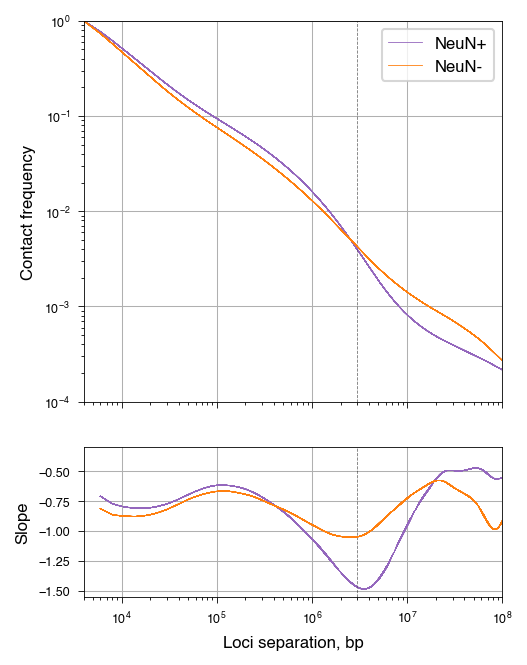

In [5]:
# Plot expected
warnings.filterwarnings('ignore')

f, axs = plt.subplots(2, 1, dpi=150, sharex=True, gridspec_kw={'height_ratios':[3, 1]}, 
                      figsize=(3.4, 4.5), 
                      layout="constrained")

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

i=0
for ct in ('NeuN+', 'NeuN-'):
    # Add distance value and drop first two columns
    cvd_smooth_agg[ct].loc[:, 's_bp'] = cvd_smooth_agg[ct]['dist'] * res
    cvd_smooth_agg[ct].loc[cvd_smooth_agg[ct]['dist'] < 2, 
                           'balanced.avg.smoothed.agg'] = np.nan
    
    # Normalize so that all lines start at 1
    cvd_smooth_agg[ct].loc[:, 'balanced.avg.smoothed.agg.norm'] = \
        cvd_smooth_agg[ct]['balanced.avg.smoothed.agg'] / \
        cvd_smooth_agg[ct]['balanced.avg.smoothed.agg'].values[2]

    # Calculate slope
    der = np.gradient(np.log(cvd_smooth_agg[ct]['balanced.avg.smoothed.agg.norm']),
                      np.log(cvd_smooth_agg[ct]['s_bp']))

    # Plot scaling
    ax = axs[0]
    ax.plot([3e6, 3e6], [1e-4, 1], 'k--', alpha=0.3)
    ax.loglog(
        cvd_smooth_agg[ct]['s_bp'],
        cvd_smooth_agg[ct]['balanced.avg.smoothed.agg.norm'],
        label=f"{ct}",
        color=colors[ct],
    )

    ax.set(ylabel='Contact frequency')
    ax.set_xlim([4000, 1e8])
    ax.set_ylim([1e-4, 1])
    ax.set_adjustable("box")
    ax.set_aspect(1)
    ax.grid(lw=0.5)
    ax.legend()

    # Plot slope
    ax = axs[1]
    ax.plot([3e6, 3e6], [-1.55, -0.3], 'k--', alpha=0.3)
    ax.semilogx(
        cvd_smooth_agg[ct]['s_bp'],
        der,
        color=colors[ct],
    )

    ax.set(
        xlabel='Loci separation, bp',
        ylabel='Slope',
    )

    ax.grid(lw=0.5)
    ax.set_xticks([1e4, 1e5, 1e6, 1e7, 1e8], minor=False)
    ax.set_ylim([-1.55, -0.3])